# Breast Cancer Detection

## Importing Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from skimage import io, color, exposure, filters
import seaborn as sb
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
# Check if TensorFlow can see your hardware
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU Available:  []


## Dataset Preprocessing

In [4]:
# Parameters
INPUT_SIZE = 128 # 264
BATCH_SIZE = 16 # 64, I was trying to prevent "ResourceExhaustedError"

SEED = 11
np.random.seed(SEED)
tf.random.set_seed(SEED)

# directories
path = "C:/Users/Gavela Maculuve/PycharmProjects/Projects_/CNN/BreastCancer/images"
trainpath = path + '/train'
validpath = path + '/valid'
testpath = path + '/test'

# our two main classes
classes = ['Benign', 'Malignant']
NUMCLASSES = len(classes)

In [5]:
def preprocess(img):
    img = img.astype('float32')
    
    min_val = np.min(img)
    max_val = np.max(img)
    
    img = (img-min_val)/(max_val - min_val + 1e-7)
    img = img-0.5
    
    return img

In [6]:
img = io.imread(trainpath + '/Benign/36_1161539227_png.rf.4ffb84ae9f0a6aca49a2d5e2403de5d9.jpg')
gray = preprocess(img)
gray.shape

(640, 640, 3)

#### Data Augment

In [7]:
# Image Data Generator
# this creates the variability in the images, so they image are not uniform
train_datagen = ImageDataGenerator(
    rotation_range = 5,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    brightness_range = None,
    shear_range = 0.1,
    zoom_range = 0.05,
    fill_mode = "nearest",
    # preprocessing_function = preprocess,
    horizontal_flip = True,
    # vertical_flip = False,
    # data_format = None,
    # validation_split = 0.0,
    # dtype = None
    rescale = 1./255
    # cval = 0.0,
    # channel_shift_range = 0.0,
    # featurewise_center = False,
    # samplewise_center = False,
    # featurewise_std_normalization = False,
    # samplewise_std_normalization = False,
    # zca_epsilon = 1e-06,
)

val_datagen = ImageDataGenerator(
    rescale = 1./255
    # preprocessing_function = preprocess # spin back
)

# Create a specific generator for evaluation/prediction
test_datagen = ImageDataGenerator(
    rescale = 1./255
    # preprocessing_function=preprocess
)

In [8]:
training_set = train_datagen.flow_from_directory(
    directory = trainpath,
    # subset = 'training',
    target_size = (INPUT_SIZE, INPUT_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical", #binary
    shuffle = True,
    seed = SEED
)

validation_set = val_datagen.flow_from_directory(
    directory = validpath,
    # subset = 'validation',
    target_size = (INPUT_SIZE, INPUT_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical", #binary
    shuffle = True, # changed??
    seed = SEED
)

test_set = test_datagen.flow_from_directory(
    directory = testpath,
    target_size = (INPUT_SIZE, INPUT_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = True,
    seed = SEED
)


Found 3111 images belonging to 2 classes.
Found 896 images belonging to 2 classes.
Found 416 images belonging to 2 classes.


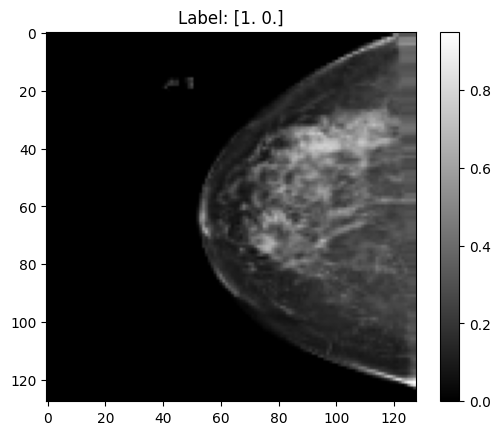

In [9]:
# Get one batch of images
images, labels = next(training_set)

# Show the first image in the batch
plt.imshow(images[0].reshape(INPUT_SIZE, INPUT_SIZE), cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.colorbar() # This will show if values are between -0.5 and 0.5
plt.show()

### Model 1

In [10]:
model = Sequential() # this is like a stacker for the layers (lego bricks base)

model.add(InputLayer(shape = [INPUT_SIZE, INPUT_SIZE, 1])) # adding batch dimension

model.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.2)) # prevent overfitting

model.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.3)) # prevent overfitting

model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.3)) # prevent overfitting

# model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
# model.add(Dropout(0.2)) # prevent overfitting

# model.add(Flatten()) # 2D -> 1D
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(NUMCLASSES, activation = 'softmax'))
# model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=1e-3, clipnorm=1.0)
model.compile(optimizer = optimizer, loss ='categorical_crossentropy', metrics=['accuracy']) #binary_crossentropy
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             1

 Total params: 118,978 (464.76 KB)

 Trainable params: 118,274 (462.01 KB)

 Non-trainable params: 704 (2.75 KB)

#### Train one

In [11]:
epochs = 30
early_stop = EarlyStopping(monitor = "val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 5, min_lr=1e-7)

history = model.fit(training_set, epochs = epochs, validation_data = validation_set, callbacks = [early_stop, reduce_lr])
model.save_weights("first-model-n-dec-31.weights.h5")
print("Saved model to disk after", epochs,"epochs.")

Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.5082 - loss: 0.8631 - val_accuracy: 0.5000 - val_loss: 0.8090 - learning_rate: 0.0010
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 193s 991ms/step - accuracy: 0.5002 - loss: 0.7866 - val_accuracy: 0.4821 - val_loss: 0.7089 - learning_rate: 0.0010
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 194s 997ms/step - accuracy: 0.5031 - loss: 0.7500 - val_accuracy: 0.5257 - val_loss: 0.7790 - learning_rate: 0.0010
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 191s 982ms/step - accuracy: 0.5252 - loss: 0.7137 - val_accuracy: 0.5279 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.5230 - loss: 0.7055 - val_accuracy: 0.5000 - val_loss: 1.0031 - learning_rate: 0.0010
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 191s 979ms/step - accuracy: 0.5342 - loss: 0.6973 - val_accuracy: 0.5011 - val_loss: 0.8517 - learning_rate: 0.0010
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 192s 986ms/step - accuracy: 0.

In [12]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

#### Analysis

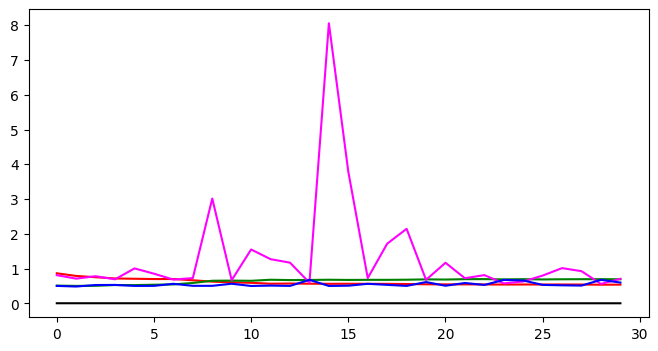

In [13]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_accuracy'],color='blue')
plt.plot(history.history['learning_rate'], color = 'black')
plt.show()

In [14]:
# 4. DEBUGGING: SEE THE RAW NUMBERS
# This reveals if the model is "dead" (0.00) or just "unsure" (0.49)
print("\n--- SANITY CHECK ---")
test_images, test_labels = next(validation_set) # Grab one batch
predictions = model.predict(test_images)

for i in range(10):
    print(f"Actual: {test_labels[i]} | Predicted Prob: {predictions[i][0]:.4f}")


--- SANITY CHECK ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Actual: [1. 0.] | Predicted Prob: 0.5442
Actual: [1. 0.] | Predicted Prob: 0.7433
Actual: [1. 0.] | Predicted Prob: 0.6451
Actual: [1. 0.] | Predicted Prob: 0.3828
Actual: [1. 0.] | Predicted Prob: 0.8677
Actual: [0. 1.] | Predicted Prob: 0.5777
Actual: [0. 1.] | Predicted Prob: 0.0040
Actual: [1. 0.] | Predicted Prob: 0.8738
Actual: [1. 0.] | Predicted Prob: 0.4818
Actual: [1. 0.] | Predicted Prob: 0.4954


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step


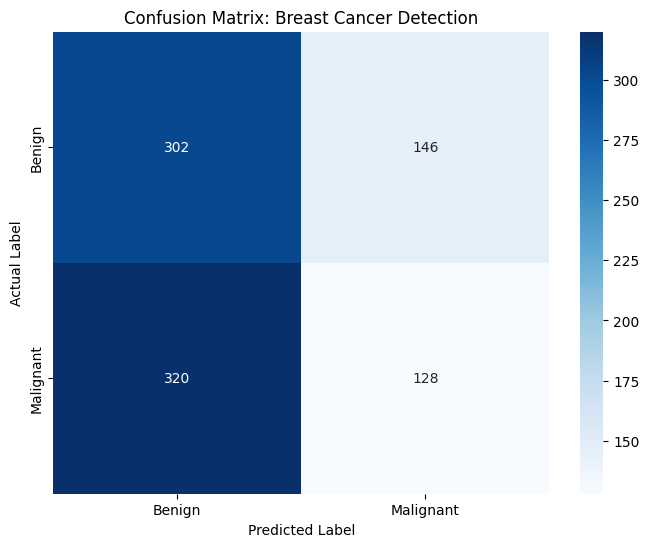

Classification Report
              precision    recall  f1-score   support

      Benign       0.49      0.67      0.56       448
   Malignant       0.47      0.29      0.35       448

    accuracy                           0.48       896
   macro avg       0.48      0.48      0.46       896
weighted avg       0.48      0.48      0.46       896



In [15]:
# 1. Get all true labels and predictions
# We turn off shuffle to ensure the labels match the predictions
validation_set.reset()
Y_pred = model.predict(validation_set)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_set.classes

# 2. Create the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plotting
plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix: Breast Cancer Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Detailed Report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=classes))

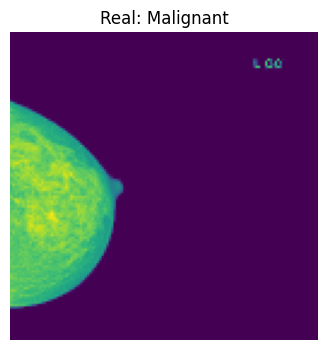

Real class: Malignant
--- Top Predictions ---
Benign: 100.00%
Malignant: 0.00%


In [16]:
# Get random image
class_name = np.random.choice(classes)
folder_path = os.path.join(trainpath, class_name)
file_name = np.random.choice([f for f in os.listdir(folder_path) if f.lower() != 'thumbs.db'])
image_path = os.path.join(folder_path, file_name)

# Load and preprocess
img_gray = io.imread(image_path, as_gray = True)
img_resized = cv2.resize(img_gray, (INPUT_SIZE,INPUT_SIZE))
img = preprocess(img_resized)
# plt.imshow(img)

# plt.plot(exposure.histogram(img)[0])
img_tensor = img.astype('float32')
img_tensor = np.expand_dims(img_tensor, axis=(0, -1))

# Print what the top predicted class is
preds = model.predict(img_tensor, verbose = 0).flatten()

# print("Output Probabilities:", preds)
order = np.argsort(preds)[::-1]
reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}

plt.figure(figsize=(6,4))
plt.imshow(img_resized)#, cmap = 'gray')
plt.title(f"Real: {class_name}")
plt.axis('off')
plt.show()

print('Real class:', class_name)
print(f"--- Top Predictions ---")
for i in range(len(classes)):
    idx = order[i]
    print(f"{reverse_class_labels[idx]}: {preds[idx]:.2%}")

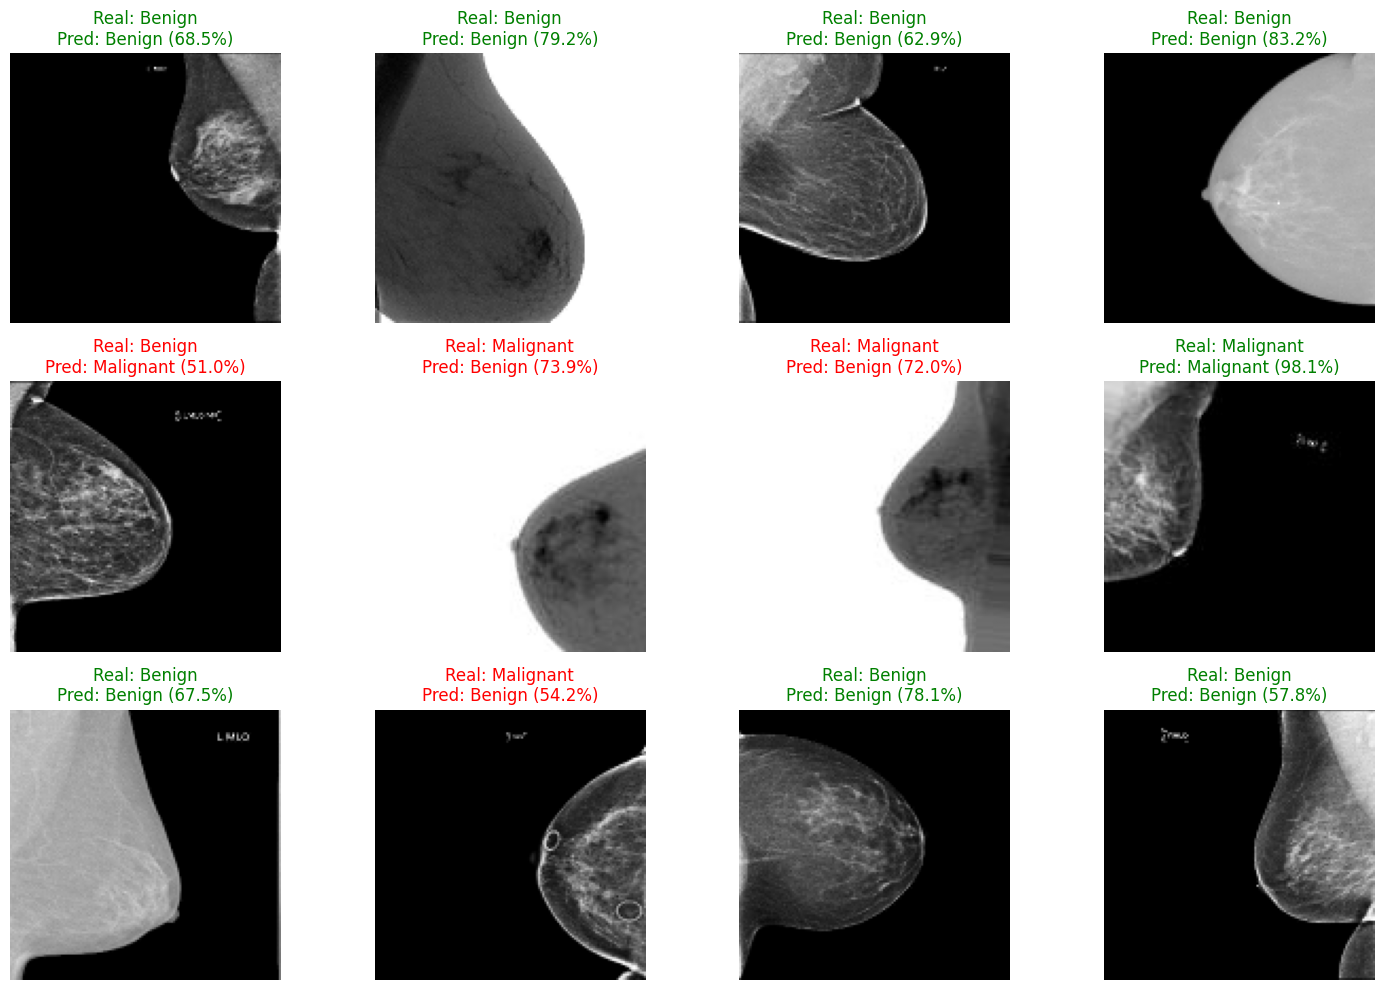

In [17]:
images, labels = next(validation_set) 

N = min(12, len(images)) # Show up to 12 images from the batch
fig = plt.figure(figsize=(15, 10))

for i in range(N):
    ax = fig.add_subplot(3, 4, i+1)
    
    # Get the actual dimensions of the image in the array
    h, w = images[i].shape[:2] 
    
    # Reshape dynamically: (1, height, width, 1)
    img_input = images[i].reshape(1, h, w, 1)
    
    # Make prediction
    pred = model.predict(img_input, verbose=0)
    
    # Convert one-hot labels back to text names
    real_label = classes[np.argmax(labels[i])] 
    pred_label = classes[np.argmax(pred)]
    confidence = np.max(pred) * 100
    
    # Display the mammogram
    ax.imshow(images[i].squeeze(), cmap='gray')
    
    # Color code the result: Green for match, Red for miss
    color = 'green' if real_label == pred_label else 'red'
    ax.set_title(f"Real: {real_label}\nPred: {pred_label} ({confidence:.1f}%)", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [18]:
# 1. Get predictions
y_pred_prob = model.predict(test_set)
print(f"Raw Prediction Shape: {y_pred_prob.shape}") # Likely (416, 2)

# 2. Convert probabilities to Class Labels (0 or 1)
if y_pred_prob.shape[1] == 2:
    # Scenario A: Model has 2 outputs [Benign, Malignant]
    # We take the index of the highest score
    y_pred = np.argmax(y_pred_prob, axis=1)
else:
    # Scenario B: Model has 1 output [Probability of Malignant]
    # We use a threshold (0.5 or 0.3)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 3. Get True Labels
y_true = test_set.classes

# 4. Generate Report
print("\n--- Final Results ---")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

# 5. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step
Raw Prediction Shape: (416, 2)

--- Final Results ---
              precision    recall  f1-score   support

      Benign       0.52      0.79      0.63       208
   Malignant       0.57      0.27      0.36       208

    accuracy                           0.53       416
   macro avg       0.54      0.53      0.50       416
weighted avg       0.54      0.53      0.50       416

[[165  43]
 [152  56]]


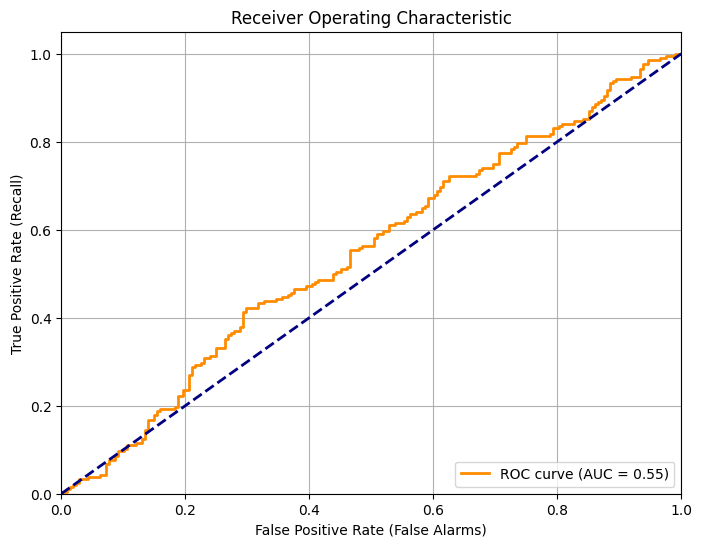

In [19]:
y_scores_malignant = y_pred_prob[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_scores_malignant)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()